## Improve the baseline using Feature Selection

Load the neccassary packackes. We will use Logistic Regression and a Random Forest classifier.

In [1]:
import itertools
import math

# Data Science
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.svm import SVC
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

# Model evaluation functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def plot_roc_curve(y_score, y_test):
    """This function plots the ROC curve 
        and gives the AUC(Area under curve) value
        
        :param y_score :predicted labels
        :param y_test  :ground truth
    """
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(fpr, tpr, color='darkorange', label=r'ROC curve (AUC = %0.2f)' % (roc_auc), lw=2, alpha=0.8)
    
    plt.xlim([-0.05, 1.01])
    plt.ylim([-0.05, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

In [4]:
def different_thresholds(model,threshold_list,X_test, y_test):
    """This function provide us with overview of the model performances when the threshold is changed.
     
        :param model                   :the selected model(LR or RF)
        :param threshold_list          :values of threshold to predict on
        :param X_test                  :the test set
        :param y_test                  :the ground truth labels
    """
    #take the predicted probabilities for each of the classes
    pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
    precisions=[] #to save the precision metric
    recalls=[]    #to save the recall metric
    f1s=[]      #to save f1 score 
    accuracies=[] #to save the accuracy
    cm=[] #to save the confusion matrix
    tp=[] #to save the true positives
    threshold_list = threshold_list
    #
    for i in threshold_list: #for each value in the threshold list make new prediction
        y_pred_new = np.where(pred_proba_df[1] > i, 1, 0)
        #calculate the precision on the new predicion
        precisions.append(precision_score(y_test, y_pred_new))
        #calculate the recall on the new predicion
        recalls.append(recall_score(y_test, y_pred_new))
        #calculate the accuracy on the new predicion
        accuracies.append(accuracy_score(y_test, y_pred_new))
        #calculate the f1 on the new predicion
        f1s.append(f1_score(y_test, y_pred_new))
        #calculate the confusion matrix on the new predicion
        cmat = confusion_matrix(y_test, y_pred_new)
        #normalize the confusion matrix
        cmat = (cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]).round(2)
        #save the true positives in a separate column
        tp.append(cmat[1,1])
        cm.append(cmat)

    new_scores=pd.DataFrame({'threshold': threshold_list, 'precision': precisions, 
                             'recall':recalls, 'accuracy':accuracies, 'f1':f1s, 'confusion_matrix':cm, 'true_positives':tp},
                            columns=['threshold', 'precision', 'recall', 'accuracy', 'f1','confusion_matrix' ,'true_positives'])
    #plot the metrics for each threshold value (new prediction)
    sns.set_style("darkgrid")
    plt.figure(1, figsize=(15, 10))
    plt.clf()
    plt.plot(new_scores['threshold'], new_scores['precision'], 'b', label='precision')
    plt.plot(new_scores['threshold'], new_scores['recall'], 'r', label='recall')
    plt.plot(new_scores['threshold'], new_scores['accuracy'], 'g', label='accuracy')
    #plt.plot(new_scores['threshold'], new_scores['true_positives'], 'y', label='tp')
    plt.ylabel('Precision Recall Accuracy', fontsize=20)
    plt.xlabel('Threshold', fontsize=20)
    plt.title('Precision Recall Accuracy over the Threshold values', fontsize=20)
    plt.legend()

## Load  the data
First we load and show the data in pandas dataframe. Then we can start transforming the data.

In [5]:
df_train = pd.read_excel('D:/krk-datascientist-master/case2/after_feature_engineering.xlsx')
print(df_train.shape)
df_train.head(5)

(1716, 32)


,CHARINDICATOR,INDICATOR,INTERNATIONALINDICATOR,ISSTRATEGIC,LEN,LENCATEGORY,MINDICATOR,NCON,PRICECLASSON,TCLASS,RETAILPACKPRICE,TRCONTE,TIPCOLOR,TRACKINGSTATUS,REGION_MARKET,LAUNCHMONTH,Successful,BRM_MERGED,BRANDONMARKET_MERGED,MARKETEDBRAND_MERGED,BRANDDIFFERENTIATOR_MERGED,ITEMSCODE_MERGED,BLDIMAGE_MERGED,PRICECLASS_MERGED,LOCALCLASS_MERGED,PCKT_MERGED,SPECIALFLAVOR_MERGED,THICATEGORY_MERGED,BRANDFAMILY_MERGED,BRANDSUBFAMILY_MERGED,BRANDSUBFAMILYGROUP_MERGED,BRANDSUBFAMILYLINE_MERGED
0,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,0.0,LENCATEGORY5,MINDICATOR2,0.0,PRICECLASSON4,TCLASS2,40.0,0.0,NOCOLOR,TRACKINGSTATUS1,REGION4_MARKET70,8,0,BRM_5_6,BRANDONMARKET_5_6,MARKETEDBRAND_5_6,BRANDDIFFERENTIATOR_10,ITEMSCODE_4,BLDIMAGE_10,PRICECLASS_10,LOCALCLASS_10,PCKT_10,SPECIALFLAVOR_10,THICATEGORY_100,BRANDFAMILY_10,BRANDSUBFAMILY_10,BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYLINE_10
1,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,0.0,LENCATEGORY2,MINDICATOR2,0.0,PRICECLASSON4,TCLASS2,11.0,0.0,NOCOLOR,TRACKINGSTATUS2,REGION4_MARKET5,6,0,BRM_1_2,BRANDONMARKET_2,MARKETEDBRAND_2,BRANDDIFFERENTIATOR_10,ITEMSCODE_4,BLDIMAGE_10,PRICECLASS_10,LOCALCLASS_10,PCKT_10,SPECIALFLAVOR_10,THICATEGORY_100,BRANDFAMILY_10,BRANDSUBFAMILY_10,BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYLINE_10
2,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,83.0,LENCATEGORY2,MINDICATOR2,0.7,PRICECLASSON4,TCLASS2,34.0,8.0,TIPCOLOR7,TRACKINGSTATUS2,REGION4_MARKET70,1,1,BRM_1_2,BRANDONMARKET_1,MARKETEDBRAND_1,BRANDDIFFERENTIATOR_10,ITEMSCODE_4,BLDIMAGE_10,PRICECLASS_10,LOCALCLASS_10,PCKT_10,SPECIALFLAVOR_10,THICATEGORY_100,BRANDFAMILY_10,BRANDSUBFAMILY_10,BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYLINE_10
3,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,74.0,LENCATEGORY5,MINDICATOR2,0.0,PRICECLASSON3,TCLASS2,3.6,8.0,TIPCOLOR1,TRACKINGSTATUS2,REGION3_MARKET38,6,1,BRM_5_6,BRANDONMARKET_5_6,MARKETEDBRAND_5_6,BRANDDIFFERENTIATOR_10,ITEMSCODE_4,BLDIMAGE_10,PRICECLASS_10,LOCALCLASS_10,PCKT_10,SPECIALFLAVOR_10,THICATEGORY_100,BRANDFAMILY_10,BRANDSUBFAMILY_10,BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYLINE_10
4,CHARINDICATOR2,INDICATOR1,INTERNATIONALINDICATOR1,ISSTRATEGIC1,100.0,LENCATEGORY1,MINDICATOR2,0.6,PRICECLASSON3,TCLASS2,20.0,8.0,TIPCOLOR1,TRACKINGSTATUS2,REGION3_MARKET23,2,0,BRM_1_2,BRANDONMARKET_1,MARKETEDBRAND_1,BRANDDIFFERENTIATOR_10,ITEMSCODE_4,BLDIMAGE_10,PRICECLASS_10,LOCALCLASS_10,PCKT_10,SPECIALFLAVOR_10,THICATEGORY_100,BRANDFAMILY_10,BRANDSUBFAMILY_10,BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYLINE_10


Transform some of the features

## Encode the categorical features to dummy features
Before using any model all categorical features should be transformed to a dummy variables of one-hot encoding, since the category does not mean anything for the model.

In [6]:
# Transform ITEMSCODE_MERGED to categorical
df_train['ITEMSCODE_MERGED']=df_train['ITEMSCODE_MERGED'].astype('category')

# Transform LAUNCHMONTH to categorical
df_train['LAUNCHMONTH']=df_train['LAUNCHMONTH'].astype('category')

# Transform the dataframe to a dataframe with dummy encoding
df_train_dummies=pd.get_dummies(df_train)

# Show the new dataframe
df_train_dummies.head(5)

,LEN,NCON,RETAILPACKPRICE,TRCONTE,Successful,CHARINDICATOR_CHARINDICATOR1,CHARINDICATOR_CHARINDICATOR2,INDICATOR_INDICATOR1,INDICATOR_INDICATOR2,INDICATOR_INDICATOR3,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR1,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR2,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR3,ISSTRATEGIC_ISSTRATEGIC1,ISSTRATEGIC_ISSTRATEGIC2,LENCATEGORY_LENCATEGORY1,LENCATEGORY_LENCATEGORY2,LENCATEGORY_LENCATEGORY3,LENCATEGORY_LENCATEGORY4,LENCATEGORY_LENCATEGORY5,MINDICATOR_MINDICATOR1,MINDICATOR_MINDICATOR2,PRICECLASSON_PRICECLASSON1,PRICECLASSON_PRICECLASSON2,PRICECLASSON_PRICECLASSON3,PRICECLASSON_PRICECLASSON4,PRICECLASSON_PRICECLASSON5,TCLASS_TCLASS1,TCLASS_TCLASS2,TCLASS_TCLASS3,TCLASS_TCLASS4,TIPCOLOR_NOCOLOR,TIPCOLOR_TIPCOLOR1,TIPCOLOR_TIPCOLOR2,TIPCOLOR_TIPCOLOR3,TIPCOLOR_TIPCOLOR4,TIPCOLOR_TIPCOLOR5,TIPCOLOR_TIPCOLOR6,TIPCOLOR_TIPCOLOR7,TRACKINGSTATUS_TRACKINGSTATUS1,TRACKINGSTATUS_TRACKINGSTATUS2,REGION_MARKET_REGION1_MARKET104,REGION_MARKET_REGION1_MARKET106,REGION_MARKET_REGION1_MARKET116,REGION_MARKET_REGION1_MARKET41,REGION_MARKET_REGION1_MARKET44,REGION_MARKET_REGION1_MARKET45,REGION_MARKET_REGION1_MARKET51,REGION_MARKET_REGION1_MARKET54,REGION_MARKET_REGION1_MARKET62,...,BRANDONMARKET_MERGED_BRANDONMARKET_5_6,BRANDONMARKET_MERGED_BRANDONMARKET_7_8_9,MARKETEDBRAND_MERGED_MARKETEDBRAND_1,MARKETEDBRAND_MERGED_MARKETEDBRAND_10,MARKETEDBRAND_MERGED_MARKETEDBRAND_2,MARKETEDBRAND_MERGED_MARKETEDBRAND_3_4,MARKETEDBRAND_MERGED_MARKETEDBRAND_5_6,MARKETEDBRAND_MERGED_MARKETEDBRAND_7_8_9,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_1,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_10,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_2,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_3_4,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_5_6,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_7_8_9,ITEMSCODE_MERGED_ITEMSCODE_1,ITEMSCODE_MERGED_ITEMSCODE_2_3,ITEMSCODE_MERGED_ITEMSCODE_4,BLDIMAGE_MERGED_BLDIMAGE_10,BLDIMAGE_MERGED_BLDIMAGE_1_3_5_6_7,PRICECLASS_MERGED_PRICECLASS_10,PRICECLASS_MERGED_PRICECLASS_1_9,LOCALCLASS_MERGED_LOCALCLASS_10,LOCALCLASS_MERGED_LOCALCLASS_1_9,PCKT_MERGED_PCKT_10,PCKT_MERGED_PCKT_1_2_3,PCKT_MERGED_PCKT_4_9,SPECIALFLAVOR_MERGED_SPECIALFLAVOR_10,SPECIALFLAVOR_MERGED_SPECIALFLAVOR_1_10,THICATEGORY_MERGED_THICATEGORY_100,THICATEGORY_MERGED_THICATEGORY_1_99,BRANDFAMILY_MERGED_BRANDFAMILY_1,BRANDFAMILY_MERGED_BRANDFAMILY_10,BRANDFAMILY_MERGED_BRANDFAMILY_2_3,BRANDFAMILY_MERGED_BRANDFAMILY_4_5_6,BRANDFAMILY_MERGED_BRANDFAMILY_7_8_9,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_1,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_10,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_2_3,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_4_5_6,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_7_8_9,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_1,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_2_3,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_4_5_6,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_7_8_9,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_1,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_10,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_2_3,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_4_5_6,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_7_8_9
0,0.0,0.0,40.0,0.0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0.0,0.0,11.0,0.0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,83.0,0.7,34.0,8.0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,74.0,0.0,3.6,8.0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0

## Create the training and testing data

Split the features form the labels

In [7]:
y = df_train_dummies['Successful'].values
X = df_train_dummies.drop(['Successful'], axis=1)
X.head(5)

,LEN,NCON,RETAILPACKPRICE,TRCONTE,CHARINDICATOR_CHARINDICATOR1,CHARINDICATOR_CHARINDICATOR2,INDICATOR_INDICATOR1,INDICATOR_INDICATOR2,INDICATOR_INDICATOR3,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR1,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR2,INTERNATIONALINDICATOR_INTERNATIONALINDICATOR3,ISSTRATEGIC_ISSTRATEGIC1,ISSTRATEGIC_ISSTRATEGIC2,LENCATEGORY_LENCATEGORY1,LENCATEGORY_LENCATEGORY2,LENCATEGORY_LENCATEGORY3,LENCATEGORY_LENCATEGORY4,LENCATEGORY_LENCATEGORY5,MINDICATOR_MINDICATOR1,MINDICATOR_MINDICATOR2,PRICECLASSON_PRICECLASSON1,PRICECLASSON_PRICECLASSON2,PRICECLASSON_PRICECLASSON3,PRICECLASSON_PRICECLASSON4,PRICECLASSON_PRICECLASSON5,TCLASS_TCLASS1,TCLASS_TCLASS2,TCLASS_TCLASS3,TCLASS_TCLASS4,TIPCOLOR_NOCOLOR,TIPCOLOR_TIPCOLOR1,TIPCOLOR_TIPCOLOR2,TIPCOLOR_TIPCOLOR3,TIPCOLOR_TIPCOLOR4,TIPCOLOR_TIPCOLOR5,TIPCOLOR_TIPCOLOR6,TIPCOLOR_TIPCOLOR7,TRACKINGSTATUS_TRACKINGSTATUS1,TRACKINGSTATUS_TRACKINGSTATUS2,REGION_MARKET_REGION1_MARKET104,REGION_MARKET_REGION1_MARKET106,REGION_MARKET_REGION1_MARKET116,REGION_MARKET_REGION1_MARKET41,REGION_MARKET_REGION1_MARKET44,REGION_MARKET_REGION1_MARKET45,REGION_MARKET_REGION1_MARKET51,REGION_MARKET_REGION1_MARKET54,REGION_MARKET_REGION1_MARKET62,REGION_MARKET_REGION1_MARKET65,...,BRANDONMARKET_MERGED_BRANDONMARKET_5_6,BRANDONMARKET_MERGED_BRANDONMARKET_7_8_9,MARKETEDBRAND_MERGED_MARKETEDBRAND_1,MARKETEDBRAND_MERGED_MARKETEDBRAND_10,MARKETEDBRAND_MERGED_MARKETEDBRAND_2,MARKETEDBRAND_MERGED_MARKETEDBRAND_3_4,MARKETEDBRAND_MERGED_MARKETEDBRAND_5_6,MARKETEDBRAND_MERGED_MARKETEDBRAND_7_8_9,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_1,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_10,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_2,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_3_4,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_5_6,BRANDDIFFERENTIATOR_MERGED_BRANDDIFFERENTIATOR_7_8_9,ITEMSCODE_MERGED_ITEMSCODE_1,ITEMSCODE_MERGED_ITEMSCODE_2_3,ITEMSCODE_MERGED_ITEMSCODE_4,BLDIMAGE_MERGED_BLDIMAGE_10,BLDIMAGE_MERGED_BLDIMAGE_1_3_5_6_7,PRICECLASS_MERGED_PRICECLASS_10,PRICECLASS_MERGED_PRICECLASS_1_9,LOCALCLASS_MERGED_LOCALCLASS_10,LOCALCLASS_MERGED_LOCALCLASS_1_9,PCKT_MERGED_PCKT_10,PCKT_MERGED_PCKT_1_2_3,PCKT_MERGED_PCKT_4_9,SPECIALFLAVOR_MERGED_SPECIALFLAVOR_10,SPECIALFLAVOR_MERGED_SPECIALFLAVOR_1_10,THICATEGORY_MERGED_THICATEGORY_100,THICATEGORY_MERGED_THICATEGORY_1_99,BRANDFAMILY_MERGED_BRANDFAMILY_1,BRANDFAMILY_MERGED_BRANDFAMILY_10,BRANDFAMILY_MERGED_BRANDFAMILY_2_3,BRANDFAMILY_MERGED_BRANDFAMILY_4_5_6,BRANDFAMILY_MERGED_BRANDFAMILY_7_8_9,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_1,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_10,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_2_3,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_4_5_6,BRANDSUBFAMILY_MERGED_BRANDSUBFAMILY_7_8_9,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_1,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_10,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_2_3,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_4_5_6,BRANDSUBFAMILYGROUP_MERGED_BRANDSUBFAMILYGROUP_7_8_9,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_1,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_10,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_2_3,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_4_5_6,BRANDSUBFAMILYLINE_MERGED_BRANDSUBFAMILYLINE_7_8_9
0,0.0,0.0,40.0,0.0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0.0,0.0,11.0,0.0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,83.0,0.7,34.0,8.0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,74.0,0.0,3.6,8.0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0

Normalize the continuous features

In [8]:
scaler = StandardScaler()
X['LEN'] = scaler.fit_transform(X[['LEN']].values.astype(float))
X['NCON'] = scaler.fit_transform(X[['NCON']].values.astype(float))
X['RETAILPACKPRICE'] = scaler.fit_transform(X[['RETAILPACKPRICE']].values.astype(float))
X['TRCONTE'] = scaler.fit_transform(X[['TRCONTE']].values.astype(float))


Split the data in training and testing set. Use stratify to split the classes equally amont train and test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, random_state=1234, test_size=.3, stratify=y)

## Run Logistic Regression classifier
We run the classifier for many steps, depending on the regularization parameter, in order to select the best regularization parameter.

In [20]:
C_param_range = np.linspace(start=10, stop=20, num=100)  # range of all C's

gsc = GridSearchCV(
    estimator=LogisticRegression(penalty='l2',solver= 'liblinear', class_weight='balanced'),
    param_grid={
        'C': C_param_range
        
        
    },
    scoring='f1',
    cv=10
)
#Keep the test set on side and use a validation set to find the best parameters
grid_result_lr = gsc.fit(X_train, y_train) 

print("Best parameter:", grid_result_lr.best_params_)
print("Best cross-validation score(f1): %s" %grid_result_lr.best_score_)


Best parameter: {'C': 18.88888888888889}
Best cross-validation score(f1): 0.44167212863189226


In [21]:
#create a model using the best paramter for C
clf = LogisticRegression(**grid_result_lr.best_params_, penalty='l2',class_weight='balanced', random_state=1234, solver= 'liblinear')
y_pred = clf.fit(X_train, y_train).predict(X_test)

print("Train Accuracy ", clf.score(X_train, y_train) * 100 , '%')
print("Test Accuracy ", accuracy_score(y_test, y_pred) * 100 , '%')

Train Accuracy  80.59950041631974 %
Test Accuracy  69.90291262135922 %


# Logistic Regression evaluation

Plot the confusion matrix

Normalized confusion matrix
[[0.72 0.28]
 [0.38 0.62]]
The precision is: 0.34269662921348315
The recall is: 0.6161616161616161
The f1 score is: 0.4404332129963899


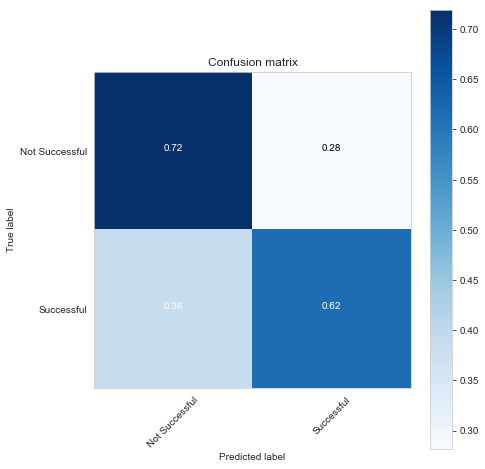

In [22]:

y_pred = clf.fit(X_train, y_train).predict(X_test)

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(1, figsize=(7, 7))
plt.clf()
plot_confusion_matrix(cm, classes=['Not Successful','Successful'], title='Confusion matrix', normalize=True)

print('The precision is: {}'.format(precision_score(y_test, y_pred)))
print('The recall is: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score is: {}'.format(f1_score(y_test, y_pred)))

Plot tha ROC Curve and AUC parameter

In [24]:
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

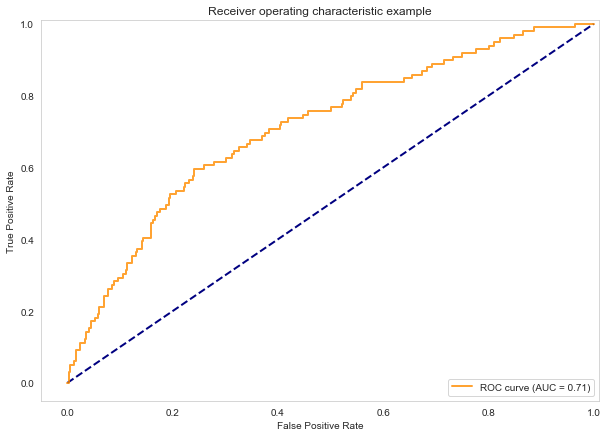

In [25]:
plot_roc_curve(y_score, y_test) #plot the curve for Logistic Regression

Coefficients learned by Logistic regression using regularization

Text(0.5,1,'Coefficients learned by Logistic regression using regularization')

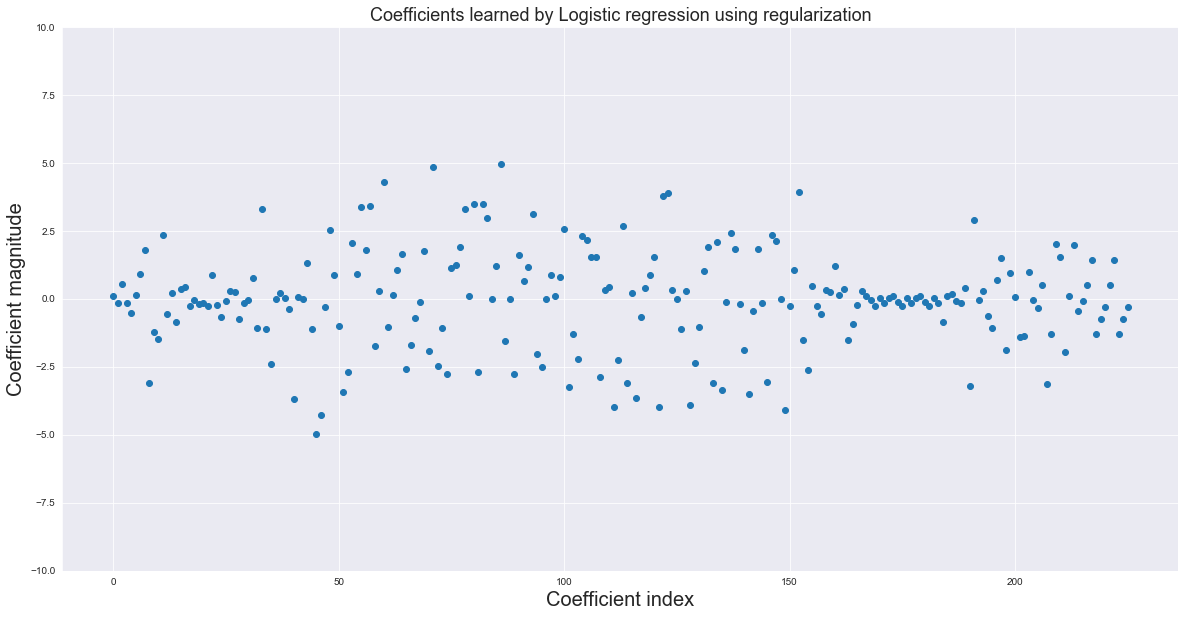

In [26]:
sns.set_style("darkgrid")
plt.figure(1, figsize=(20, 10))
plt.plot(clf.coef_.T, 'o')
plt.ylim(-10,10)
#plt.xticks(np.arange(len(X.columns)), X.columns, fontsize='6', rotation=90)
plt.xlabel("Coefficient index", fontsize=20)
plt.ylabel("Coefficient magnitude", fontsize=20)
plt.title('Coefficients learned by Logistic regression using regularization', fontsize=18)


Text(0,0.5,'Feature')

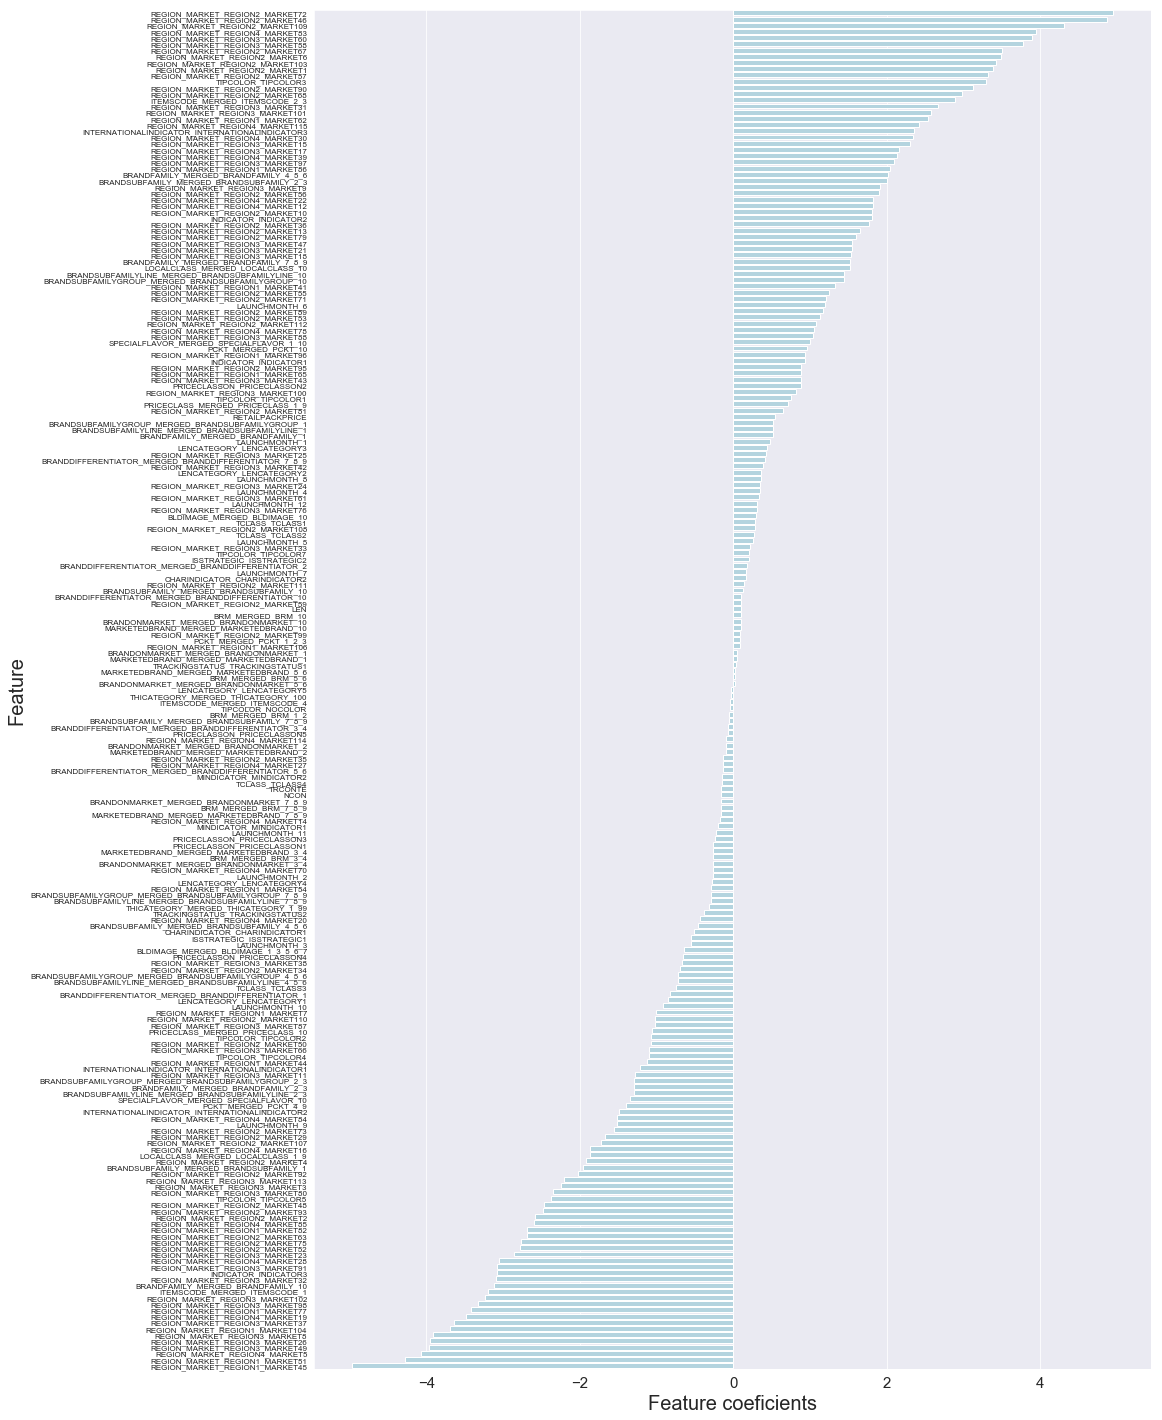

In [27]:
#We can also check the value of the coeffiecients in a tabular format 
coef = np.array(clf.coef_[0])
col = np.array(X.columns)
coef_value = pd.DataFrame({'feature': col, 'coeficient': coef}, columns=['feature', 'coeficient'])
coef_value=coef_value.sort_values('coeficient', ascending=False)

#when using L1 regularization many some features are zero aka ignored by the model
coef_not_zero = coef_value[coef_value['coeficient']!=0] #check which one are not ignored by the model
coef_not_zero.shape


plt.figure(1, figsize=(15, 25))
sns.barplot(x=coef_not_zero['coeficient'],y=coef_not_zero['feature'], data=coef_not_zero, color='lightblue')
plt.yticks(np.arange(len(coef_not_zero['feature'].unique())), coef_not_zero['feature'].unique(), fontsize='8')
plt.xticks(fontsize='15') 
plt.xlabel("Feature coeficients", fontsize='20')
plt.ylabel("Feature", fontsize='20')

# Run Random Forest Classifier
We run the Random Forest Classifier using Grid Search to find the most optimal parameters such as the number of estimators, the number of features and the depth of the trees. 

In [28]:
estimators = range(70, 140, 10) #the number of trees that are build
features = range (50, 90, 10) #The number of features selected by the model
depths = range(5,20,5) #limiting the max depth of a tree

#Create a GridSearchCV object. In param_grid we scpecifythe parameters to search over.
gsc_forest = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': estimators,
        'max_features' : features,
        'max_depth': depths
        
    },
    scoring='f1',
    cv=10
)
#Keep the test set on side and use a validation set to find the best parameters
grid_result_forest = gsc_forest.fit(X_train, y_train) 
print("Best parameters : %s" % grid_result_forest.best_params_)
print("Best cross-validation score(f1): %s" %grid_result_forest.best_score_)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Best parameters : {'max_depth': 15, 'max_features': 80, 'n_estimators': 70}
Best cross-validation score(f1): 0.26086227766825243


In [29]:
#Create the model using the best paramters
forest = RandomForestClassifier(**grid_result_forest.best_params_)

forest.fit(X_train, y_train) #fit the model

print("Accuracy on training set:{:.3f}".format(forest.score(X_train,y_train) *100,'%')+" %")
print("Accuracy on testing set:{:.3f}".format(forest.score(X_test,y_test) *100, '%')+" %")


Accuracy on training set:94.754 %
Accuracy on testing set:82.136 %


# Random Forest evaluation

Check the confusion matrix

Normalized confusion matrix
[[0.97 0.03]
 [0.82 0.18]]
The precision is: 0.6206896551724138
The recall is: 0.18181818181818182
The f1 score is: 0.28125


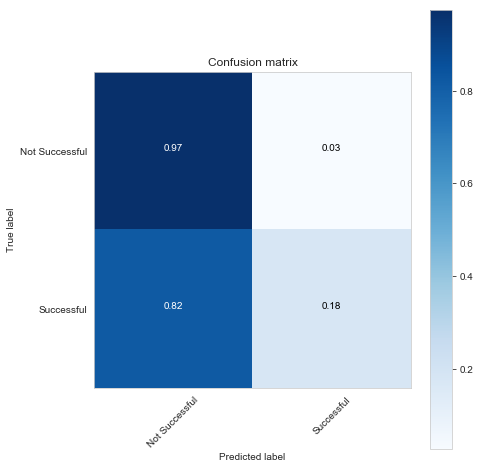

In [30]:
# Compute confusion matrix
y_pred_forest = forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred_forest)
np.set_printoptions(precision=2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(1, figsize=(7, 7))
plt.clf()
plot_confusion_matrix(cm, classes=['Not Successful','Successful'], title='Confusion matrix', normalize=True)

print('The precision is: {}'.format(precision_score(y_test, y_pred_forest)))
print('The recall is: {}'.format(recall_score(y_test, y_pred_forest)))
print('The f1 score is: {}'.format(f1_score(y_test, y_pred_forest)))

Also plot the ROC curve

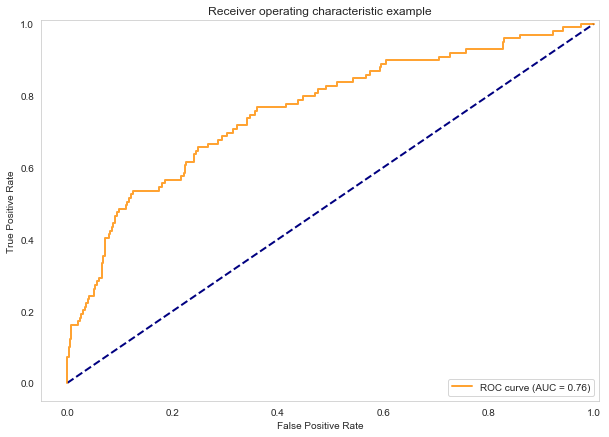

In [31]:
y_score_forest=forest.fit(X_train, y_train).predict_proba(X_test)
plot_roc_curve(y_score_forest, y_test)

One of the properities of RandomForestClassifier is the feature importance, which rates how important each feature is for a decision a tree makes. It is a number between 0 an 1 for each feature, where 0 is not used at all and 1 means perfectly predicts the target.

In [32]:
#We can put that in a dataframe and visualize it using barplots
fi = np.array(forest.feature_importances_)
col = np.array(X.columns)
feature_importance = pd.DataFrame({'feature': col, 'importance': fi}, columns=['feature', 'importance'])
feature_importance=feature_importance.sort_values('importance', ascending=False)
feature_importance = feature_importance.reset_index()

In [33]:
def plot_feature_importance(df):
    """This is a function that vusualizes the most important features selected by RandomForest.
    
    :param df       :the features we want to plot
    """
    plt.figure(1, figsize=(10, 5))
    sns.barplot(x=df['importance'],y=df['feature'], data=df, color='lightblue')
    plt.yticks(np.arange(len(df['feature'].unique())), df['feature'].unique(), fontsize='10')
    plt.xticks(fontsize='15') 
    plt.xlabel("Feature importance", fontsize='15')
    plt.ylabel("Feature", fontsize='15')

Plot the 20 most important features

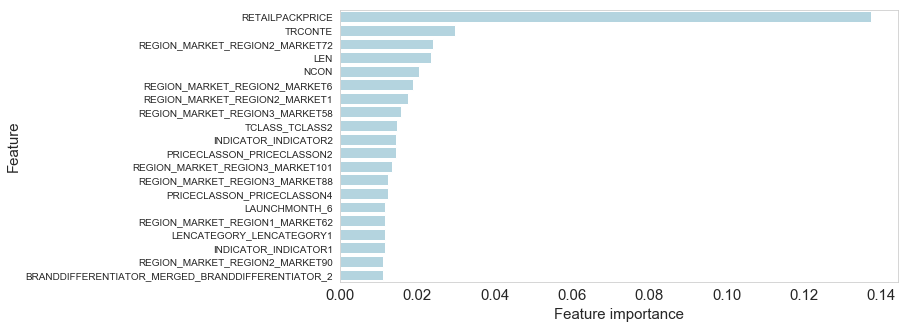

In [35]:
plot_feature_importance(feature_importance.head(20))

# Different values for the threshold

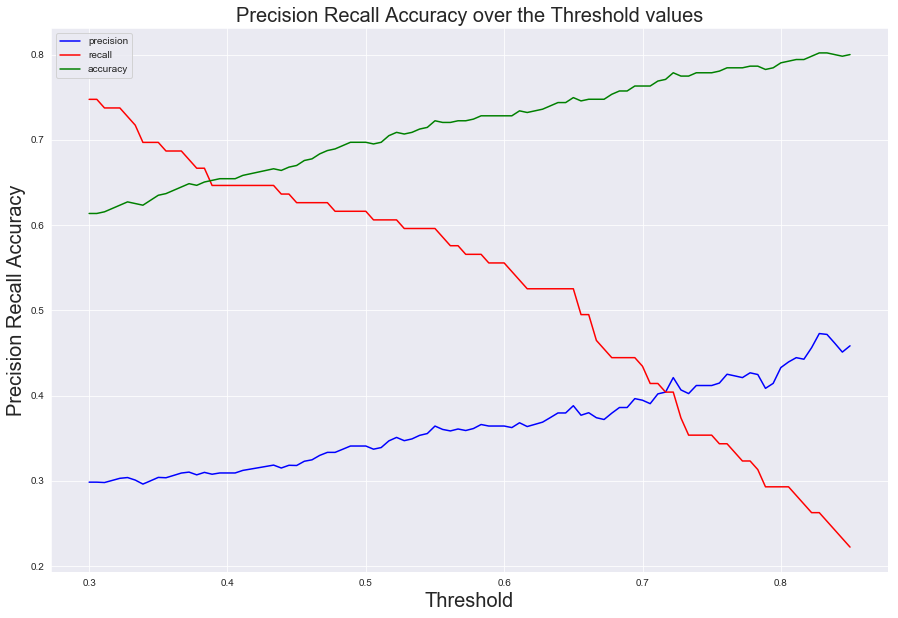

In [15]:
threshold_list = np.linspace(start=0.3, stop=0.85, num=100)
different_thresholds(clf,threshold_list, X_test, y_test)

On one hand, as the True positives ( Successful - Successful ) decreases the number of False Negatives ( Successful - Not successfull) increases thus the Recall decreases (TP/TP+FN). On the other hand, as TP decreases, the number of False Positives decreases - we are more certain about the positivity of the samples, thus the Precision increases.